In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd

from util import engineer_features, prep_X_y

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")

sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_dfs = engineer_features(sorted_dyads_df)

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_17147/6524477.py:12: DtypeWarning: Columns (131,132,133) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
/Users/zhu.henian/projects/pistachio/util.py:150: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [31]:
import pickle
from typing import Any, Literal

from flaml import AutoML
from numba.tests.doctest_usecase import d
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    fbeta_score,
    make_scorer,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import (
    FixedThresholdClassifier,
    KFold,
    PredefinedSplit,
    StratifiedGroupKFold,
    StratifiedKFold,
    TimeSeriesSplit,
    TunedThresholdClassifierCV,
)
from tqdm.auto import tqdm
from xgboost import XGBClassifier

from hr_model import HrModel
from util import FeatureSetDataFrames


def specificity_score(y_true, y_pred) -> float:
    tn = ((y_true == 0) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    if (tn + fp) == 0:
        return float("nan")
    return tn / (tn + fp)


def find_threshold_ref_specificity(model, X, y, *, verbose=False) -> float:
    hr_model = HrModel()

    ref_y_pred = hr_model.predict(X)
    ref_specificity = specificity_score(y, ref_y_pred)
    ref_recall = recall_score(y, ref_y_pred, zero_division=np.nan)

    y_pred_proba = model.predict_proba(X)
    thresholds = np.logspace(-5, 0, 100)

    for th in thresholds:
        y_pred = (y_pred_proba[:, 1] >= th).astype(int)
        specificity = specificity_score(y, y_pred)
        recall = recall_score(y, y_pred, zero_division=np.nan)
        if specificity >= ref_specificity:
            if verbose:
                print(f"Selected threshold: {th}")
                print(f"Selected specificity: {specificity}, recall: {recall}")
                print(f"Reference specificity: {ref_specificity}, recall: {ref_recall}")
            return th

    raise ValueError("No suitable threshold found!")


def find_threshold_ref_specificity_cv(model, df_train, df_val, cv, verbose=False):
    X, y = prep_X_y(pd.concat([df_train, df_val]), "tantrum_within_60m")
    thresholds = []
    for train_idx, val_idx in cv.split(df_train):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        th: int | float = find_threshold_ref_specificity(
            model, X_val, y_val, verbose=verbose
        )
        thresholds.append(th)

    best_threshold = float(np.mean(thresholds))
    if verbose:
        print(f"Cross-validated best threshold: {best_threshold:.4f}")

    model.fit(X, y)
    return FixedThresholdClassifier(model, threshold=best_threshold)


def youdens_j_score(y_true, y_pred) -> float:
    sensitivity = recall_score(y_true, y_pred, zero_division=np.nan)
    specificity = specificity_score(y_true, y_pred)
    return sensitivity + specificity - 1


TuningMethod = (
    Literal["balanced_accuracy"]
    | Literal["youden_index"]
    | Literal["cost_sensitive"]
    | Literal["ref_specificity"]
)


def create_dyad_cv(df_train: pd.DataFrame, n_splits: int = 5) -> PredefinedSplit:
    # Create 5-fold CV based on "dyad"
    dyad_labels = df_train["dyad"]
    skf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = np.zeros(len(df_train), dtype=int)
    for fold_idx, (_, val_idx) in enumerate(
        skf.split(np.zeros(len(dyad_labels)), dyad_labels)
    ):
        folds[val_idx] = fold_idx
    return PredefinedSplit(folds)


def cost_sensitive_score(y, y_pred):
    cm = confusion_matrix(y, y_pred, labels=[0, 1])

    gain_matrix = np.array(
        [
            [0, -1],  # gain for false positives
            [-200, 0],  # gain for false negatives
        ]
    )
    return np.sum(cm * gain_matrix)


def train_model(
    df_train,
    df_val,
    hyperparams: dict[str, Any],
    tuning_method: TuningMethod,
):
    model = XGBClassifier(**hyperparams)
    X_train, y_train = prep_X_y(pd.concat([df_train, df_val]), "tantrum_within_60m")
    cv = (
        create_dyad_cv(df_train)
        if len(df_val) == 0
        else PredefinedSplit(test_fold=[-1] * len(df_train) + [0] * len(df_val))
    )

    thresholds = np.logspace(-5, 0, 100)
    if tuning_method == "balanced_accuracy":
        tuned_model = TunedThresholdClassifierCV(
            model,
            scoring="balanced_accuracy",
            thresholds=thresholds,
            cv=cv,
            n_jobs=-1,
        )
        tuned_model.fit(X_train, y_train)
        return tuned_model
    elif tuning_method == "youden_index":
        tuned_model = TunedThresholdClassifierCV(
            model,
            scoring=make_scorer(youdens_j_score),
            thresholds=thresholds,
            cv=cv,
            n_jobs=-1,
        )
        tuned_model.fit(X_train, y_train)
        return tuned_model
    elif tuning_method == "cost_sensitive":
        tuned_model = TunedThresholdClassifierCV(
            model,
            scoring=make_scorer(cost_sensitive_score),
            thresholds=thresholds,
            cv=cv,
            n_jobs=-1,
        )
        tuned_model.fit(X_train, y_train)
        return tuned_model
    elif tuning_method == "ref_specificity":
        return find_threshold_ref_specificity_cv(
            model, df_train, df_val, cv, verbose=False
        )
    else:
        raise ValueError(f"Unknown tuning method: {tuning_method}")


def bootstrap(df: pd.DataFrame, n_samples: int) -> pd.DataFrame:
    boot_df = pd.DataFrame()
    for _ in range(n_samples):
        boot_df = pd.concat(
            [
                boot_df,
                df.sample(frac=1, replace=True, random_state=None),
            ]
        )
    return boot_df


def train_and_get_dyad_models(
    df_population: pd.DataFrame,
    df_test: pd.DataFrame,
    mode: str,
    week: int,
    dyad_models: dict[str, TunedThresholdClassifierCV],
    tuning_method: TuningMethod,
):
    min_week = df_test["therapy_week"].min()
    if week == min_week:
        return dyad_models

    new_dyad_models = {}
    bootstrap_level = df_test["dyad"].nunique()
    match mode:
        case "no_retrain":
            return dyad_models
        case "retrain_dyad":
            for dyad, dyad_df in tqdm(df_test.groupby("dyad"), leave=False):
                add_df = dyad_df[dyad_df["therapy_week"] < week]
                add_df = bootstrap(add_df, bootstrap_level)

                df_train = pd.concat(
                    [df_population, add_df[add_df["therapy_week"] < week - 1]]
                )
                df_val = add_df[add_df["therapy_week"] == week - 1]
                new_dyad_models[dyad] = train_model(
                    df_train,
                    df_val,
                    dyad_models[dyad].estimator.get_params(),
                    tuning_method,
                )
        case _:
            raise ValueError(f"Unknown mode: {mode}")

    return new_dyad_models


def retrain_and_predict(
    base_model,
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    mode: str,
    tuning_method: TuningMethod,
):
    dyad_models = {d: base_model for d in df_test["dyad"].unique()}
    weekly_results = []
    weekly_models = []
    weeks = df_test["therapy_week"].unique()
    weeks_iter = sorted(weeks[weeks >= 0])
    for week in tqdm(weeks_iter):
        dyad_models = train_and_get_dyad_models(
            df_train,
            df_test,
            mode,
            week,
            dyad_models=dyad_models,
            tuning_method=tuning_method,
        )
        weekly_models.append((week, dyad_models))
        week_df = df_test[df_test["therapy_week"] == week]

        week_pred_proba = np.empty((0, 2))
        week_preds = np.array([])
        week_trues = np.array([])
        week_thresholds = np.array([])

        for dyad, dyad_week_df in week_df.groupby("dyad"):
            X, y = prep_X_y(dyad_week_df, "tantrum_within_60m")
            model = dyad_models[dyad]

            y_pred_proba = model.predict_proba(X)
            y_pred = model.predict(X)

            week_pred_proba = np.concatenate([week_pred_proba, y_pred_proba])
            week_preds = np.concatenate([week_preds, y_pred])
            week_trues = np.concatenate([week_trues, y.values])
            threshold = (
                model.best_threshold_
                if isinstance(model, TunedThresholdClassifierCV)
                else 0.5
            )
            week_thresholds = np.append(week_thresholds, threshold)

        print(
            f"Week {week} sensitivity: {recall_score(week_trues, week_preds)}, specificity: {specificity_score(week_trues, week_preds)}"
        )
        weekly_results.append(
            (week, week_pred_proba, week_preds, week_trues, week_thresholds)
        )

    return weekly_results, weekly_models


supersets_to_test = [
    ["watch"],
    ["watch", "demographic"],
    ["watch", "medical"],
    ["watch", "demographic", "medical"],
]
feature_supersets = {
    "watch": [
        "hr",
        "activity",
        "sleep",
        "stress",
        "overnight_hrv",
    ],
    "demographic": [
        "child_demo",
        "parent_demo",
    ],
    "medical": [
        "medical",
        "therapy",
    ],
}


automl_settings = {
    # "max_iter": 25,
    "time_budget": 15,
    "train_time_limit": 2,  # seconds
    "pred_time_limit": 1,  # seconds
    "task": "classification",
    # "metric": "log_loss",
    "estimator_list": ["xgboost"],
    "early_stop": True,
}


def eval_model_on_feature_sets(
    supersets_to_test: list[list[str]],
    dfs: FeatureSetDataFrames,
    weeks: tuple[int, int],
    mode: str,
    tuning_method: TuningMethod,
    verbose: bool = False,
) -> dict[str, Any]:
    feature_set_results = {}
    for supersets in supersets_to_test:
        features = [fs for superset in supersets for fs in feature_supersets[superset]]
        combined_df = pd.concat(
            [
                cleaned_dyads_dfs["index"],
                cleaned_dyads_dfs["response"],
            ]
            + [cleaned_dyads_dfs[fs] for fs in features],
            axis=1,
        )

        name = "_".join(supersets)
        print(f"Feature sets: {name}")

        combined_df = combined_df[
            (combined_df["therapy_week"].between(weeks[0], weeks[1]))
        ]
        df_train = combined_df[combined_df["Arm_Sham"]]
        df_test = combined_df[~combined_df["Arm_Sham"]]

        # Create 5-fold CV based on "dyad"
        dyad_labels = df_train["dyad"]
        skf = KFold(n_splits=5, shuffle=True, random_state=42)
        folds = np.zeros(len(df_train), dtype=int)
        for fold_idx, (_, val_idx) in enumerate(
            skf.split(np.zeros(len(dyad_labels)), dyad_labels)
        ):
            folds[val_idx] = fold_idx
        cv = PredefinedSplit(folds)
        X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")

        automl = AutoML()
        automl.fit(
            X_train,
            y_train,
            **automl_settings,
            verbose=verbose,
            eval_method="cv",
            split_type="group",
            groups=df_train["dyad"],
        )
        tuned_model = train_model(
            df_train,
            pd.DataFrame(),
            automl.best_config,
            tuning_method=tuning_method,
        )
        results, models = retrain_and_predict(
            tuned_model, df_train, df_test, mode=mode, tuning_method=tuning_method
        )

        data_dir = Path("./intermediate_data")
        data_dir.mkdir(parents=True, exist_ok=True)
        with open(data_dir / f"{tuning_method}_{mode}_{name}_results.pkl", "wb") as f:
            pickle.dump(results, f)

        feature_set_results[name] = results
    return feature_set_results

In [45]:
# Params
weeks = (0, 15)
tuning_method: TuningMethod = "youden_index"

In [46]:
full_df = pd.concat(list(cleaned_dyads_dfs.values()), axis=1)
full_df = full_df[full_df["therapy_week"].between(weeks[0], weeks[1])]
full_df_train = full_df[full_df["Arm_Sham"]]
full_df_test = full_df[~full_df["Arm_Sham"]]

X_train, y_train = prep_X_y(full_df_train, "tantrum_within_60m")

hr_model_results, _ = retrain_and_predict(
    HrModel(),
    full_df_train,
    full_df_test,
    mode="no_retrain",
    tuning_method=tuning_method,
)

  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.3333333333333333, specificity: 0.7446904654315409
Week 1 sensitivity: 0.3695652173913043, specificity: 0.7517335975005716
Week 2 sensitivity: 0.32786885245901637, specificity: 0.7285432173780951
Week 3 sensitivity: 0.5254237288135594, specificity: 0.7478005865102639
Week 4 sensitivity: 0.41935483870967744, specificity: 0.7384223081352307
Week 5 sensitivity: 0.15, specificity: 0.7433825792551554
Week 6 sensitivity: 0.25, specificity: 0.7295734454791228
Week 7 sensitivity: 0.5510204081632653, specificity: 0.7325240022216932
Week 8 sensitivity: 0.5227272727272727, specificity: 0.7411782409149048
Week 9 sensitivity: 0.38636363636363635, specificity: 0.7373343725643025
Week 10 sensitivity: 0.45, specificity: 0.7558263518659558
Week 11 sensitivity: 0.4, specificity: 0.7445109780439122
Week 12 sensitivity: 0.3170731707317073, specificity: 0.7440354464894342
Week 13 sensitivity: 0.625, specificity: 0.7489822261940224
Week 14 sensitivity: 0.75, specificity: 0.7220693450742

In [47]:
no_retrain_results = eval_model_on_feature_sets(
    supersets_to_test=supersets_to_test,
    dfs=cleaned_dyads_dfs,
    weeks=weeks,
    mode="no_retrain",
    tuning_method=tuning_method,
    verbose=True,
)

Feature sets: watch


  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.7092198581560284, specificity: 0.5346437716523573
Week 1 sensitivity: 0.8043478260869565, specificity: 0.5229749295130687
Week 2 sensitivity: 0.8032786885245902, specificity: 0.535014431110436
Week 3 sensitivity: 0.7627118644067796, specificity: 0.5598086124401914
Week 4 sensitivity: 0.8387096774193549, specificity: 0.5602533519782841
Week 5 sensitivity: 0.3, specificity: 0.5432440751000308
Week 6 sensitivity: 0.6666666666666666, specificity: 0.5600030039050766
Week 7 sensitivity: 0.7142857142857143, specificity: 0.5490756169166071
Week 8 sensitivity: 0.6590909090909091, specificity: 0.5557896320818599
Week 9 sensitivity: 0.7272727272727273, specificity: 0.5434138737334373
Week 10 sensitivity: 0.8, specificity: 0.5651942117288652
Week 11 sensitivity: 1.0, specificity: 0.5720865960386918
Week 12 sensitivity: 0.6341463414634146, specificity: 0.5518916155419223
Week 13 sensitivity: 0.9375, specificity: 0.5435408598947473
Week 14 sensitivity: 1.0, specificity: 0.53577

  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.3617021276595745, specificity: 0.7197620123512577
Week 1 sensitivity: 0.2608695652173913, specificity: 0.7203383372704412
Week 2 sensitivity: 0.4262295081967213, specificity: 0.6993771836548686
Week 3 sensitivity: 0.3728813559322034, specificity: 0.7392344497607656
Week 4 sensitivity: 0.41935483870967744, specificity: 0.7195031668997286
Week 5 sensitivity: 0.4, specificity: 0.7065250846414282
Week 6 sensitivity: 0.25, specificity: 0.6969059777711024
Week 7 sensitivity: 0.4489795918367347, specificity: 0.6763469015313814
Week 8 sensitivity: 0.36363636363636365, specificity: 0.735911519073057
Week 9 sensitivity: 0.18181818181818182, specificity: 0.7114575214341388
Week 10 sensitivity: 0.25, specificity: 0.686062452399086
Week 11 sensitivity: 0.32, specificity: 0.7372946414862582
Week 12 sensitivity: 0.43902439024390244, specificity: 0.6947000681663258
Week 13 sensitivity: 0.75, specificity: 0.6678582067322014
Week 14 sensitivity: 1.0, specificity: 0.6411667583929554

  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.3333333333333333, specificity: 0.7855851784907365
Week 1 sensitivity: 0.2608695652173913, specificity: 0.7983692753181437
Week 2 sensitivity: 0.32786885245901637, specificity: 0.7903691326143096
Week 3 sensitivity: 0.4576271186440678, specificity: 0.7758913412563667
Week 4 sensitivity: 0.5483870967741935, specificity: 0.7617833347042856
Week 5 sensitivity: 0.2, specificity: 0.7640812557710065
Week 6 sensitivity: 0.5, specificity: 0.7895764493841995
Week 7 sensitivity: 0.20408163265306123, specificity: 0.7706101721812267
Week 8 sensitivity: 0.20454545454545456, specificity: 0.7834624934165977
Week 9 sensitivity: 0.4772727272727273, specificity: 0.8384255650818394
Week 10 sensitivity: 0.5, specificity: 0.8424219345011424
Week 11 sensitivity: 0.16, specificity: 0.8451558421618302
Week 12 sensitivity: 0.1951219512195122, specificity: 0.825068166325835
Week 13 sensitivity: 0.0, specificity: 0.8553271770429948
Week 14 sensitivity: 0.0, specificity: 0.8408090258668134
We

  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.5957446808510638, specificity: 0.5900738062961289
Week 1 sensitivity: 0.6086956521739131, specificity: 0.6551093499961899
Week 2 sensitivity: 0.45901639344262296, specificity: 0.6565395716238797
Week 3 sensitivity: 0.711864406779661, specificity: 0.6780367340638987
Week 4 sensitivity: 0.6774193548387096, specificity: 0.652052315538373
Week 5 sensitivity: 0.2, specificity: 0.6465066174207449
Week 6 sensitivity: 0.5833333333333334, specificity: 0.6721988585160709
Week 7 sensitivity: 0.7755102040816326, specificity: 0.6331825755772436
Week 8 sensitivity: 0.6136363636363636, specificity: 0.6556316304266044
Week 9 sensitivity: 0.75, specificity: 0.659547934528449
Week 10 sensitivity: 0.75, specificity: 0.6713632901751714
Week 11 sensitivity: 0.84, specificity: 0.6764163979732842
Week 12 sensitivity: 0.34146341463414637, specificity: 0.6372699386503068
Week 13 sensitivity: 0.1875, specificity: 0.6732201370271076
Week 14 sensitivity: 0.0, specificity: 0.6684094661529995


In [50]:
import warnings

warnings.filterwarnings("ignore")

test_case = [
    ["watch"],
    ["watch", "demographic"],
    ["watch", "medical"],
    ["watch", "demographic", "medical"],
]

retrain_dyad_results = eval_model_on_feature_sets(
    supersets_to_test=test_case,
    dfs=cleaned_dyads_dfs,
    weeks=weeks,
    mode="retrain_dyad",
    tuning_method=tuning_method,
    verbose=False,
)

Feature sets: watch


  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.7092198581560284, specificity: 0.5346437716523573


  0%|          | 0/21 [00:00<?, ?it/s]

Week 1 sensitivity: 0.8260869565217391, specificity: 0.659529071096548


  0%|          | 0/21 [00:00<?, ?it/s]

Week 2 sensitivity: 0.6557377049180327, specificity: 0.8115600789913413


  0%|          | 0/21 [00:00<?, ?it/s]

Week 3 sensitivity: 0.7627118644067796, specificity: 0.6768019756135206


  0%|          | 0/21 [00:00<?, ?it/s]

Week 4 sensitivity: 0.12903225806451613, specificity: 0.8225713580653121


  0%|          | 0/21 [00:00<?, ?it/s]

Week 5 sensitivity: 0.4, specificity: 0.8064789165897199


  0%|          | 0/21 [00:00<?, ?it/s]

Week 6 sensitivity: 0.16666666666666666, specificity: 0.8919345148693302


  0%|          | 0/21 [00:00<?, ?it/s]

Week 7 sensitivity: 0.22448979591836735, specificity: 0.9175593112750933


  0%|          | 0/21 [00:00<?, ?it/s]

Week 8 sensitivity: 0.6363636363636364, specificity: 0.8775863366187646


  0%|          | 0/21 [00:00<?, ?it/s]

Week 9 sensitivity: 0.22727272727272727, specificity: 0.8460639127045986


  0%|          | 0/21 [00:00<?, ?it/s]

Week 10 sensitivity: 0.3, specificity: 0.8968012185833968


  0%|          | 0/21 [00:00<?, ?it/s]

Week 11 sensitivity: 0.2, specificity: 0.9058037770612621


  0%|          | 0/21 [00:00<?, ?it/s]

Week 12 sensitivity: 0.5365853658536586, specificity: 0.843558282208589


  0%|          | 0/21 [00:00<?, ?it/s]

Week 13 sensitivity: 0.9375, specificity: 0.7551385165326184


  0%|          | 0/21 [00:00<?, ?it/s]

Week 14 sensitivity: 0.0, specificity: 0.8904788112272978


  0%|          | 0/21 [00:00<?, ?it/s]

Week 15 sensitivity: 0.36363636363636365, specificity: 0.921031029387621
Feature sets: watch_demographic


  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.3617021276595745, specificity: 0.7197620123512577


  0%|          | 0/21 [00:00<?, ?it/s]

Week 1 sensitivity: 0.9130434782608695, specificity: 0.6553379562600016


  0%|          | 0/21 [00:00<?, ?it/s]

Week 2 sensitivity: 0.5901639344262295, specificity: 0.8180161020811181


  0%|          | 0/21 [00:00<?, ?it/s]

Week 3 sensitivity: 0.3898305084745763, specificity: 0.8789164994597932


  0%|          | 0/21 [00:00<?, ?it/s]

Week 4 sensitivity: 0.25806451612903225, specificity: 0.8189520440898248


  0%|          | 0/21 [00:00<?, ?it/s]

Week 5 sensitivity: 0.25, specificity: 0.8111726685133888


  0%|          | 0/21 [00:00<?, ?it/s]

Week 6 sensitivity: 0.0, specificity: 0.9126614598978672


  0%|          | 0/21 [00:00<?, ?it/s]

Week 7 sensitivity: 0.08163265306122448, specificity: 0.9462826311195747


  0%|          | 0/21 [00:00<?, ?it/s]

Week 8 sensitivity: 0.4772727272727273, specificity: 0.9048980513129186


  0%|          | 0/21 [00:00<?, ?it/s]

Week 9 sensitivity: 0.5681818181818182, specificity: 0.7939984411535463


  0%|          | 0/21 [00:00<?, ?it/s]

Week 10 sensitivity: 0.3, specificity: 0.8412033511043412


  0%|          | 0/21 [00:00<?, ?it/s]

Week 11 sensitivity: 0.24, specificity: 0.9117918010133579


  0%|          | 0/21 [00:00<?, ?it/s]

Week 12 sensitivity: 0.5365853658536586, specificity: 0.8726141785957737


  0%|          | 0/21 [00:00<?, ?it/s]

Week 13 sensitivity: 0.6875, specificity: 0.8125310296892067


  0%|          | 0/21 [00:00<?, ?it/s]

Week 14 sensitivity: 1.0, specificity: 0.9024490919097413


  0%|          | 0/21 [00:00<?, ?it/s]

Week 15 sensitivity: 0.2727272727272727, specificity: 0.8885240518798226
Feature sets: watch_medical


  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.3333333333333333, specificity: 0.7855851784907365


  0%|          | 0/21 [00:00<?, ?it/s]

Week 1 sensitivity: 0.8260869565217391, specificity: 0.5826411643679037


  0%|          | 0/21 [00:00<?, ?it/s]

Week 2 sensitivity: 0.4426229508196721, specificity: 0.827358347258089


  0%|          | 0/21 [00:00<?, ?it/s]

Week 3 sensitivity: 0.7627118644067796, specificity: 0.6700879765395894


  0%|          | 0/21 [00:00<?, ?it/s]

Week 4 sensitivity: 0.25806451612903225, specificity: 0.6870115982561488


  0%|          | 0/21 [00:00<?, ?it/s]

Week 5 sensitivity: 0.25, specificity: 0.781009541397353


  0%|          | 0/21 [00:00<?, ?it/s]

Week 6 sensitivity: 0.0, specificity: 0.89283568639231


  0%|          | 0/21 [00:00<?, ?it/s]

Week 7 sensitivity: 0.24489795918367346, specificity: 0.9373958581290169


  0%|          | 0/21 [00:00<?, ?it/s]

Week 8 sensitivity: 0.8181818181818182, specificity: 0.8036265141825295


  0%|          | 0/21 [00:00<?, ?it/s]

Week 9 sensitivity: 0.5227272727272727, specificity: 0.7984411535463757


  0%|          | 0/21 [00:00<?, ?it/s]

Week 10 sensitivity: 0.6, specificity: 0.825971058644326


  0%|          | 0/21 [00:00<?, ?it/s]

Week 11 sensitivity: 0.16, specificity: 0.8975126669737448


  0%|          | 0/21 [00:00<?, ?it/s]

Week 12 sensitivity: 0.6829268292682927, specificity: 0.8202113156100886


  0%|          | 0/21 [00:00<?, ?it/s]

Week 13 sensitivity: 1.0, specificity: 0.7115480091351405


  0%|          | 0/21 [00:00<?, ?it/s]

Week 14 sensitivity: 1.0, specificity: 0.914694551458448


  0%|          | 0/21 [00:00<?, ?it/s]

Week 15 sensitivity: 0.6363636363636364, specificity: 0.9271055655885733
Feature sets: watch_demographic_medical


  0%|          | 0/16 [00:00<?, ?it/s]

Week 0 sensitivity: 0.5957446808510638, specificity: 0.5900738062961289


  0%|          | 0/21 [00:00<?, ?it/s]

Week 1 sensitivity: 0.6304347826086957, specificity: 0.7397698696944296


  0%|          | 0/21 [00:00<?, ?it/s]

Week 2 sensitivity: 0.18032786885245902, specificity: 0.8515874221479569


  0%|          | 0/21 [00:00<?, ?it/s]

Week 3 sensitivity: 0.7796610169491526, specificity: 0.7451767248032104


  0%|          | 0/21 [00:00<?, ?it/s]

Week 4 sensitivity: 0.3548387096774194, specificity: 0.797318417372707


  0%|          | 0/21 [00:00<?, ?it/s]

Week 5 sensitivity: 0.15, specificity: 0.791320406278855


  0%|          | 0/21 [00:00<?, ?it/s]

Week 6 sensitivity: 0.0, specificity: 0.8754130369480324


  0%|          | 0/21 [00:00<?, ?it/s]

Week 7 sensitivity: 0.2653061224489796, specificity: 0.8798698722526382


  0%|          | 0/21 [00:00<?, ?it/s]

Week 8 sensitivity: 0.7272727272727273, specificity: 0.8411707170265593


  0%|          | 0/21 [00:00<?, ?it/s]

Week 9 sensitivity: 0.36363636363636365, specificity: 0.798908807482463


  0%|          | 0/21 [00:00<?, ?it/s]

Week 10 sensitivity: 0.35, specificity: 0.8688499619192689


  0%|          | 0/21 [00:00<?, ?it/s]

Week 11 sensitivity: 0.12, specificity: 0.8851527713803163


  0%|          | 0/21 [00:00<?, ?it/s]

Week 12 sensitivity: 0.5609756097560976, specificity: 0.8230231765507839


  0%|          | 0/21 [00:00<?, ?it/s]

Week 13 sensitivity: 1.0, specificity: 0.6635885214973687


  0%|          | 0/21 [00:00<?, ?it/s]

Week 14 sensitivity: 0.0, specificity: 0.9054760594386351


  0%|          | 0/21 [00:00<?, ?it/s]

Week 15 sensitivity: 0.13636363636363635, specificity: 0.9461500574618289


# Analysis


In [ ]:
from pathlib import Path

tuning_method: TuningMethod = "youden_index"
feature_sets = [
    "watch",
    "watch_demographic",
    "watch_medical",
    "watch_demographic_medical",
]
data_dir = Path("./intermediate_data")
no_retrain_results = {
    k: pickle.load(open(data_dir / f"{tuning_method}_no_retrain_{k}_results.pkl", "rb"))
    for k in feature_sets
}
retrain_dyad_results = {
    k: pickle.load(
        open(data_dir / f"{tuning_method}_retrain_dyad_{k}_results.pkl", "rb")
    )
    for k in feature_sets
}

                                              AUROC  Sensitivity  Specificity
Model                                                                        
HR range (105-129)                            0.570        0.398        0.741
Watch - No Retrain                            0.657        0.729        0.549
Watch, Demographic - No Retrain               0.572        0.380        0.703
Watch, Medical - No Retrain                   0.664        0.307        0.805
Watch, Demographic, Medical - No Retrain      0.658        0.576        0.655
Watch - Retrain Weekly                        0.756        0.539        0.810
Watch, Demographic - Retrain Weekly           0.772        0.425        0.840
Watch, Medical - Retrain Weekly               0.764        0.502        0.798
Watch, Demographic, Medical - Retrain Weekly  0.775        0.468        0.807


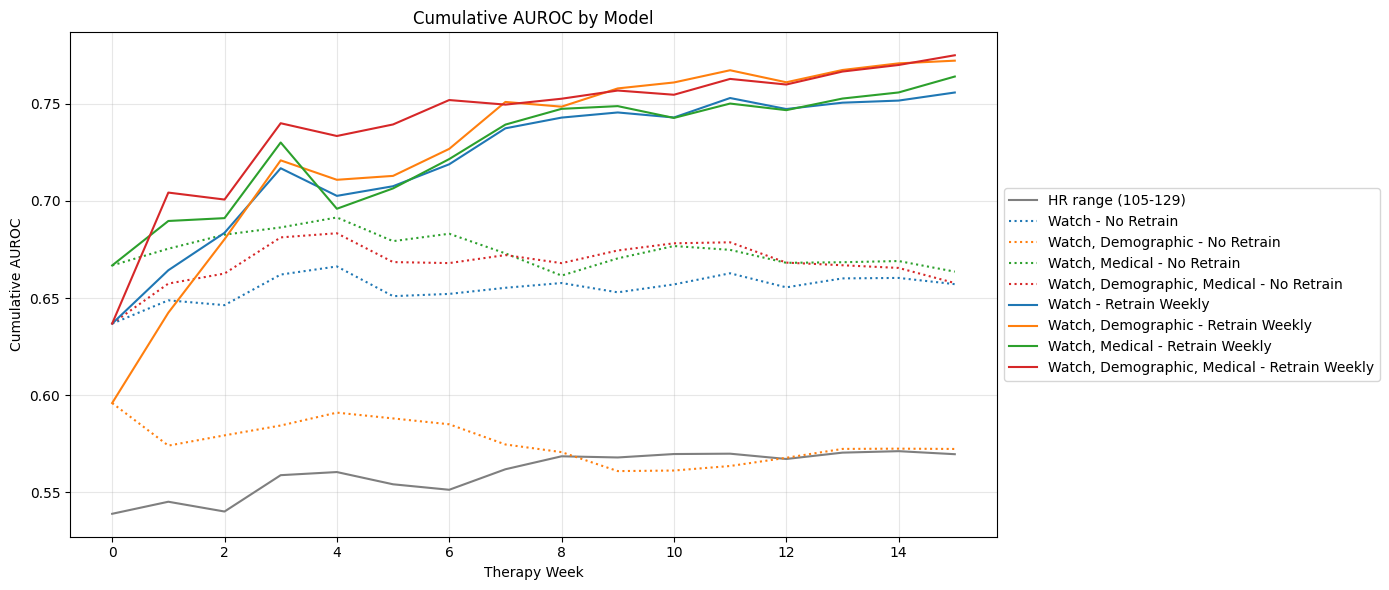

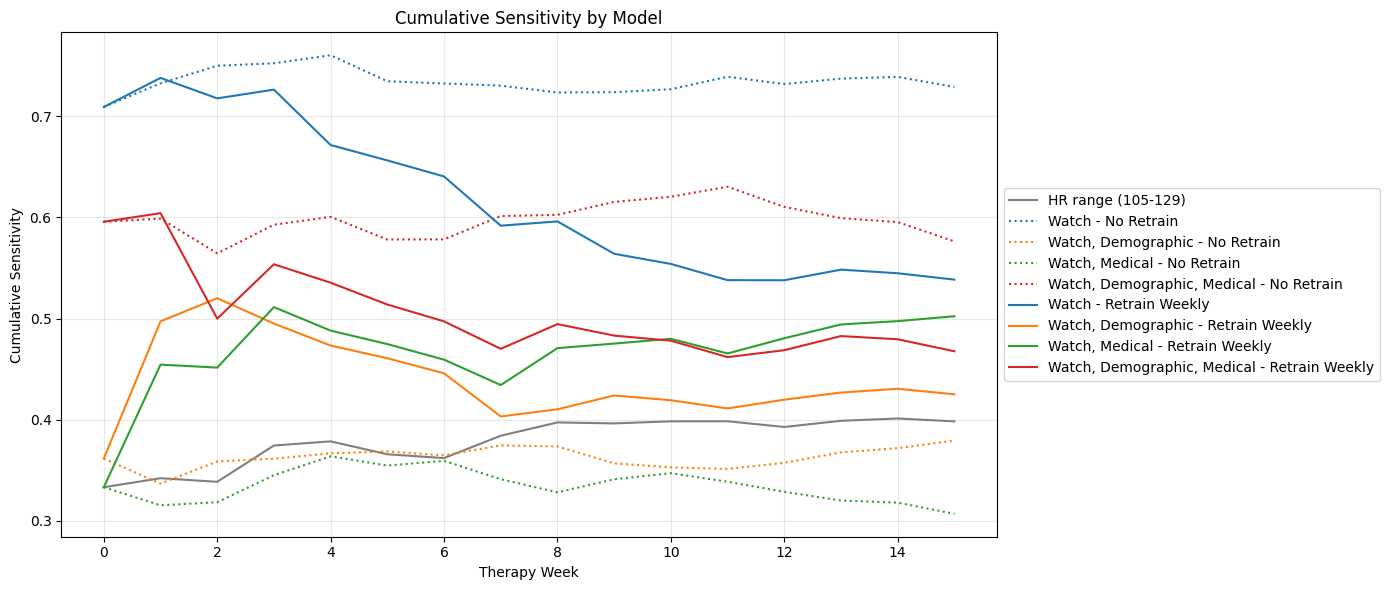

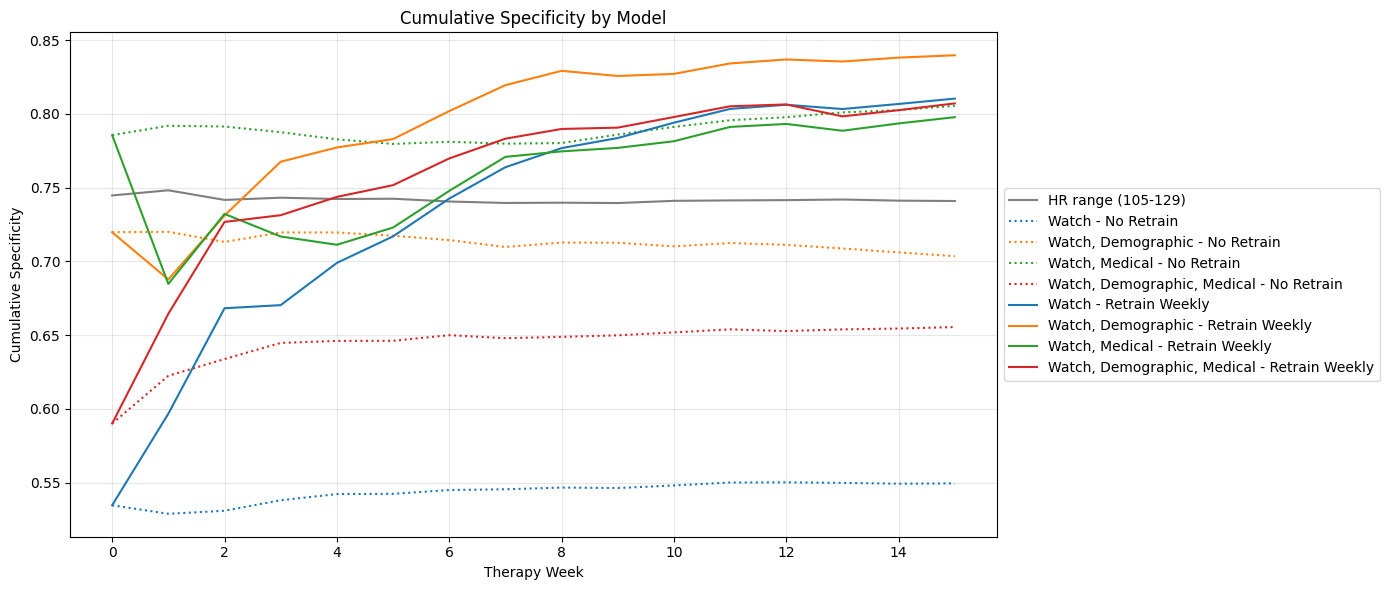

In [51]:
import matplotlib.pyplot as plt
import pandas as pd


def plot_weekly_cum_metric(metric_name, metric_fn):
    def weekly_cum_metric(results, metric_fn):
        metrics = []
        all_y_pred_proba = np.empty((0, 2))
        all_y_pred = np.array([])
        all_y_true = np.array([])
        for week, y_pred_proba, y_pred, y_true, _ in results:
            all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
            all_y_pred = np.concatenate([all_y_pred, y_pred])
            all_y_true = np.concatenate([all_y_true, y_true])

            if metric_fn is roc_auc_score:
                metric = metric_fn(all_y_true, all_y_pred_proba[:, 1])
            else:
                metric = metric_fn(all_y_true, all_y_pred)
            metrics.append((week, metric))
        return metrics

    hr_cum_auc = weekly_cum_metric(hr_model_results, metric_fn)
    no_retrain_watch_cum_auc = weekly_cum_metric(no_retrain_results["watch"], metric_fn)
    no_retrain_demographic_cum_auc = weekly_cum_metric(
        no_retrain_results["watch_demographic"], metric_fn
    )
    no_retrain_medical_metric = weekly_cum_metric(
        no_retrain_results["watch_medical"], metric_fn
    )
    no_retrain_all_features_metric = weekly_cum_metric(
        no_retrain_results["watch_demographic_medical"], metric_fn
    )
    retrain_watch_cum_auc = weekly_cum_metric(retrain_dyad_results["watch"], metric_fn)
    retrain_demographic_cum_auc = weekly_cum_metric(
        retrain_dyad_results["watch_demographic"], metric_fn
    )
    retrain_medical_metric = weekly_cum_metric(
        retrain_dyad_results["watch_medical"], metric_fn
    )
    retrain_medical_cum_auc = weekly_cum_metric(
        retrain_dyad_results["watch_demographic_medical"], metric_fn
    )

    plt.figure(figsize=(14, 6))
    plt.plot(*zip(*hr_cum_auc), label="HR range (105-129)", color="tab:grey")

    plt.plot(*zip(*no_retrain_watch_cum_auc), label="Watch - No Retrain", linestyle=":")
    plt.plot(
        *zip(*no_retrain_demographic_cum_auc),
        label="Watch, Demographic - No Retrain",
        linestyle=":",
    )
    plt.plot(
        *zip(*no_retrain_medical_metric),
        label="Watch, Medical - No Retrain",
        linestyle=":",
    )
    plt.plot(
        *zip(*no_retrain_all_features_metric),
        label="Watch, Demographic, Medical - No Retrain",
        linestyle=":",
    )

    plt.plot(
        *zip(*retrain_watch_cum_auc), label="Watch - Retrain Weekly", color="tab:blue"
    )

    plt.plot(
        *zip(*retrain_demographic_cum_auc),
        label="Watch, Demographic - Retrain Weekly",
        color="tab:orange",
    )
    plt.plot(
        *zip(*retrain_medical_metric),
        label="Watch, Medical - Retrain Weekly",
        color="tab:green",
    )
    plt.plot(
        *zip(*retrain_medical_cum_auc),
        label="Watch, Demographic, Medical - Retrain Weekly",
        color="tab:red",
    )

    plt.xlabel("Therapy Week")
    plt.ylabel(f"Cumulative {metric_name}")
    plt.title(f"Cumulative {metric_name} by Model")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def get_final_metrics():
    def get_final_metric(results, metric_fn):
        all_y_pred_proba = np.empty((0, 2))
        all_y_pred = np.array([])
        all_y_true = np.array([])
        for _, y_pred_proba, y_pred, y_true, _ in results:
            all_y_pred_proba = np.concatenate([all_y_pred_proba, y_pred_proba])
            all_y_pred = np.concatenate([all_y_pred, y_pred])
            all_y_true = np.concatenate([all_y_true, y_true])
        if metric_fn is roc_auc_score:
            return metric_fn(all_y_true, all_y_pred_proba[:, 1])
        else:
            return metric_fn(all_y_true, all_y_pred)

    models = [
        ("HR range (105-129)", hr_model_results),
        ("Watch - No Retrain", no_retrain_results["watch"]),
        (
            "Watch, Demographic - No Retrain",
            no_retrain_results["watch_demographic"],
        ),
        ("Watch, Medical - No Retrain", no_retrain_results["watch_medical"]),
        (
            "Watch, Demographic, Medical - No Retrain",
            no_retrain_results["watch_demographic_medical"],
        ),
        ("Watch - Retrain Weekly", retrain_dyad_results["watch"]),
        (
            "Watch, Demographic - Retrain Weekly",
            retrain_dyad_results["watch_demographic"],
        ),
        ("Watch, Medical - Retrain Weekly", retrain_dyad_results["watch_medical"]),
        (
            "Watch, Demographic, Medical - Retrain Weekly",
            retrain_dyad_results["watch_demographic_medical"],
        ),
    ]
    # Collect metrics into a DataFrame and print as markdown

    rows = []
    for name, results in models:
        auroc = get_final_metric(results, roc_auc_score)
        sensitivity = get_final_metric(results, recall_score)
        specificity = get_final_metric(results, specificity_score)
        rows.append(
            {
                "Model": name,
                "AUROC": round(auroc, 3),
                "Sensitivity": round(sensitivity, 3),
                "Specificity": round(specificity, 3),
            }
        )
    return pd.DataFrame(rows).set_index("Model")


print(get_final_metrics())
plot_weekly_cum_metric("AUROC", roc_auc_score)
plot_weekly_cum_metric("Sensitivity", recall_score)
plot_weekly_cum_metric("Specificity", specificity_score)

In [ ]:
# How much can we improve the HR range model

import itertools

from sklearn.metrics import roc_auc_score

from hr_model import HrModel

full_df = pd.concat(list(cleaned_dyads_dfs.values()), axis=1)
full_df = full_df[full_df["therapy_week"].between(weeks[0], weeks[1])]
full_df_train = full_df[full_df["Arm_Sham"]]
full_df_test = full_df[~full_df["Arm_Sham"]]

X_train, y_train = prep_X_y(full_df_train, "tantrum_within_60m")

best_auc = -1
best_hr_low = None
best_hr_high = None
best_sens = None
best_spec = None

hr_lows = range(50, 150, 2)
hr_highs = range(100, 200, 2)

for combo in tqdm(list(itertools.product(hr_lows, hr_highs))):
    hr_low, hr_high = combo

    if hr_high <= hr_low:
        continue
    # Predict using HR range
    y_pred = (
        (full_df_train["hr_moving_avg_10m"] >= hr_low)
        & (full_df_train["hr_moving_avg_10m"] <= hr_high)
    ).astype(int)
    y_true = y_train

    # Only evaluate where hr_moving_avg_10m is not NaN
    mask = full_df_train["hr_moving_avg_10m"].notna()
    if mask.sum() == 0:
        continue

    auc = roc_auc_score(y_true[mask], y_pred[mask])
    sens = recall_score(y_true[mask], y_pred[mask])
    spec = specificity_score(y_true[mask], y_pred[mask])

    if auc > best_auc:
        best_auc = auc
        best_hr_low = hr_low
        best_hr_high = hr_high
        best_sens = sens
        best_spec = spec

print(f"Best HR range: {best_hr_low}-{best_hr_high}")
print(f"ROC-AUC: {best_auc:.3f}")
print(f"Sensitivity: {best_sens:.3f}")
print(f"Specificity: {best_spec:.3f}")